# Data generation and analysis for appendix "Alternative Systematicity Measures"

This notebook can be used to generate the data and reproduce the analysis of the appendix "Alternative Systematicity Measures" of the technical report ["Assessing a Formal Model of Reflective Equilibrium"](https://re-models.github.io/re-technical-report/). 

## How to run this notebook

There are several possibilities to execute this notebook. You can, for instance,

1. execute this notebook on Colab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/re-models/re-technical-report/blob/main/notebooks/appendix_systematicity_measures.ipynb), or
2. execute this notebook locally in, for instance, [JupyterLab](https://jupyter.org/) by cloning the Github repository of the report (for details, see <https://github.com/re-models/re-technical-report>).


## Installing and importing libraries

In [1]:
!pip install numpy==1.23.1
!pip install seaborn==0.12.2
!pip install re-technical-report

## Data Generating

In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from IPython.display import clear_output
from theodias import (
    StandardPosition, 
    DAGDialecticalStructure,
    DialecticalStructure, 
    Position
)
from theodias.util import create_random_argument_list, random_position_as_set

from math import log
from os import getcwd, path
from pathlib import Path
from re_technical_report import (
    sys_bbb,
    sys_mm,
    sys_ec,
    sys_ec_2,
    sys_csw_beta,
    sys_csw_alpha,
    sys_rec,
    sys_grec,
    sigma_content,
    restricted_sigma,
    conditional_restricted_sigma,
)

In [28]:
# Directories that are use to save generated tables.
data_dir = path.join(Path(getcwd()).parent.absolute(), "data")
# Are we on Colab?
on_colab = 'google.colab' in str(get_ipython())
print(f"On colab: {on_colab}")

On colab: False


### Creating data for Sigma-based measures

We now create a number of random taus and loop through every theorycandidate. The resulting systematicty values will be stored in a dataframe.

In [29]:
# creating random dias
if not on_colab:
    n_dialectical_structures = 100
else:
    n_dialectical_structures = 2

n = 7
arguments_lists = [create_random_argument_list(n_arguments_min=3, 
                            n_arguments_max=8,
                            n_sentences = n, 
                            n_premises_max = 2)  for i in range(n_dialectical_structures)]

rows = []
print("Created dialectical structures.")
# looping through dias
i = 0
for arguments in arguments_lists:
    #print(arguments)
    i += 1
    clear_output(wait=True)
    print(f"Generating data for {i}-th dialectical structure (out of {n_dialectical_structures}).") 
    ds = DAGDialecticalStructure.from_arguments(arguments, n)
    sig_tau = ds.n_complete_extensions()
    # calculating normalising denominator for s_siglig_2 
    domains = [StandardPosition.from_set(ds.sentence_pool().as_set()-{i},n).domain() for i in range(1,n)]
    denom = max([log(restricted_sigma(ds, restricted_domain),2) for restricted_domain in domains])

    # looping through all theory candidates
    for theory in ds.consistent_positions():
        # exclude empty theory
        if theory.size() != 0:
            row = {}
            # for reproducibility
            row["tau"] = ds.get_arguments()
            row["theory"] = theory.as_set()
        
            # calculation of all relevant data
            row["theory_size"] = theory.size()
            row["theory_clos_size"] = ds.closure(theory).size()
            row["n"] = ds.sentence_pool().size()
            row["sig_theory"] = ds.n_complete_extensions(theory)
            row["sig_tau"] = sig_tau
            
            restricted_domain = StandardPosition.from_set(ds.sentence_pool().domain().as_set() - theory.domain().as_set(), n)
            row["sig_restr"] = restricted_sigma(ds,restricted_domain)
            row["sig_restr_theory"] = conditional_restricted_sigma(ds, restricted_domain, theory)
            
            row["sys_grec"] = sys_grec(ds, theory)
            row["sigma_content"] = sigma_content(ds, theory)
            
            rows.append(row)

data_grec = pd.DataFrame(rows)

#display(data.head())

Generating data for 1-th dialectical structure (out of 1).


In [5]:
# saving data:
if not on_colab:
    output_file = path.join(data_dir, 'systematicity_data.csv')
    data_grec.to_csv(output_file)

### Creating data for "simple" measures 

In [25]:
n = 7
# creating a data frame with all possible combination of theory size and theory closure size
rows = []
for theory_size in range(1, n+1):
    for theory_clos_size in range(theory_size, n+1):
        rows.append({'n':n,'theory_size':theory_size, 'theory_clos_size': theory_clos_size})

df_basis = DataFrame(rows)

#display(df_basis)

def sys_df(fun, df_basis, sys_name, parameters=None, parameter_name = None):
    if parameters is None:
        df_sys_data = df_basis.copy()
        df_sys_data['systematicity'] = df_sys_data.apply(lambda x: fun(x), axis=1)
        df_sys_data['systematicity_type'] = sys_name
        return df_sys_data
    else:
        df_sys_data_all = DataFrame()
        for parameter in parameters:
            df_sys_data = df_basis.copy()
            df_sys_data['systematicity'] = df_sys_data.apply(lambda x: fun(x, parameter), axis=1)
            df_sys_data['systematicity_type'] = sys_name
            df_sys_data[parameter_name]=parameter
            df_sys_data_all = pd.concat([df_sys_data_all, df_sys_data], ignore_index=True)
        return df_sys_data_all
    
sys_data = DataFrame()

# Standard systematicity
sys_data = pd.concat([sys_data, 
                      sys_df(lambda x: sys_bbb(x['theory_size'], x['theory_clos_size']), 
                             df_basis,
                             'sys_bbb')],
                      ignore_index=True)
#df_sys_data_all.append(, ignore_index=True)
# SysMinMut (minimal mutation)
sys_data = pd.concat([sys_data,
                     sys_df(lambda x,y: sys_mm(x['theory_size'], x['theory_clos_size'],y),
                            df_basis,
                           'sys_mm',
                            parameters = [0.1,0.2,0.5,0.7,0.9,0.95,0.99],
                            parameter_name='gamma')], 
                     ignore_index=True)
# Effective content size (s_ec)
sys_data = pd.concat([sys_data,
                     sys_df(lambda x: sys_ec(x['theory_size'], x['theory_clos_size'], x['n']),
                            df_basis,
                           'sys_ec')], 
                     ignore_index=True)

# Quadratic effective content size (s_ec^2)
sys_data = pd.concat([sys_data,
                     sys_df(lambda x: sys_ec_2(x['theory_size'], x['theory_clos_size'],  x['n']),
                            df_basis,
                           'sys_ec_2')], 
                     ignore_index=True)

# Content simplicity weighted (alpha)
sys_data = pd.concat([sys_data,
                     sys_df(lambda x,y: sys_csw_alpha(x['theory_size'], 
                                                      x['theory_clos_size'], 
                                                      x['n'], alpha=y),
                            df_basis,
                           'sys_csw_alpha',
                            parameters = [0.1,0.3,0.5,0.7,0.9],
                            parameter_name='alpha')], 
                     ignore_index=True)

# Content simplicity weighted (beta)
sys_data = pd.concat([sys_data,
                     sys_df(lambda x,y: sys_csw_beta(x['theory_size'], 
                                                     x['theory_clos_size'], 
                                                     x['n'], beta = y),
                            df_basis,
                           'sys_csw_beta',
                            parameters = [0.1,0.3,0.525,0.7,0.9],
                            parameter_name='beta')], 
                     ignore_index=True)
# Relative effective content systematicit (s_{rec}) 
sys_data = pd.concat([sys_data,
                     sys_df(lambda x: sys_rec(x['theory_size'], x['theory_clos_size'], x['n']),
                            df_basis,
                           'sys_rec')],
                     ignore_index=True)

In [ ]:
# saving data:
if not on_colab:
    output_file = path.join(data_dir, 'systematicity_data_simple_measures.csv')
    sys_data.to_csv(output_file, index=False)

## Data Analysis

Note that in contrast to the other chapters, we created the plots of the appendix "Alternative Systematicity Measures" within the corresponding quarto file. (In other words, we did not export the plots as pdf/png files.)

In [23]:
from os import getcwd, path
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

from re_technical_report import plot_sys_measure

# loading data

# if not on colab we rely on the saved/exported data
if not on_colab:
    data_dir = path.join(Path(getcwd()).parent.absolute(), "data")
    # data for the sigma based measure
    data_file = path.join(data_dir, 'systematicity_data.csv')   
    data_grec = pd.read_csv(path.join(data_dir, data_file))
    # data for "simple" measures
    sys_data = pd.read_csv(path.join(data_dir, 'systematicity_data_simple_measures.csv'))

### Simple Measures

#### Standard Measure ($S_{BBB}$)

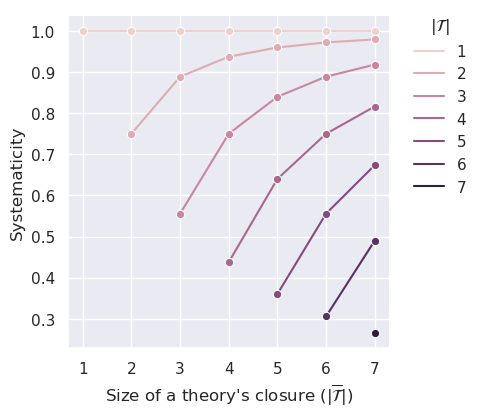

In [26]:
# sys_bbb
plot_sys_measure(sys_data, "sys_bbb", scale=0.8)
plt.show()

#### Minimal Mutation Systematicity

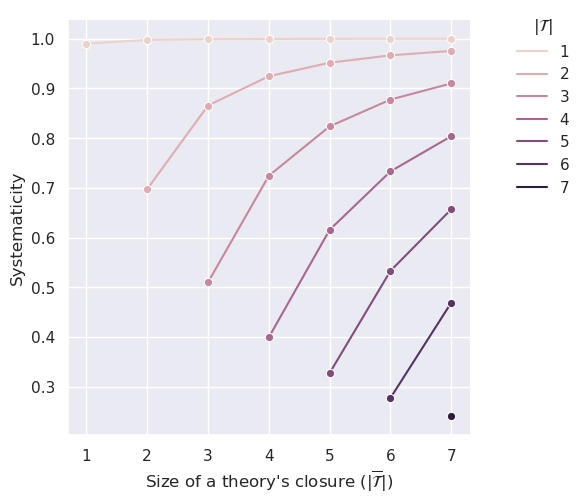

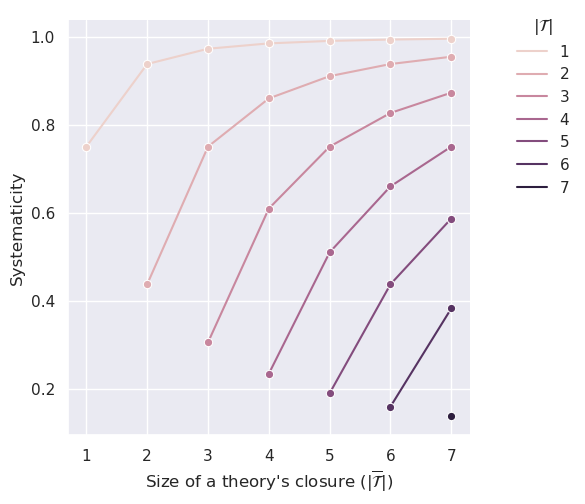

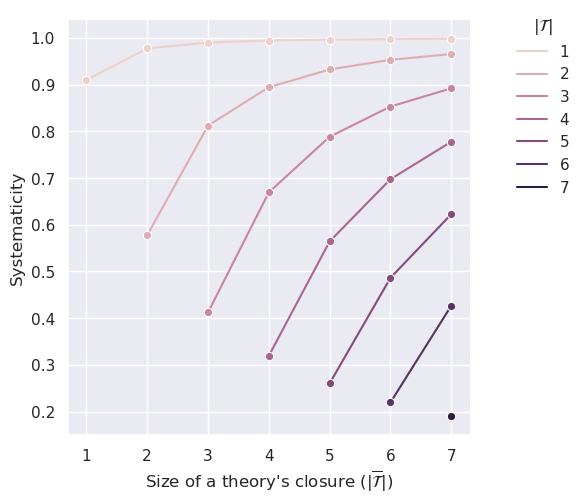

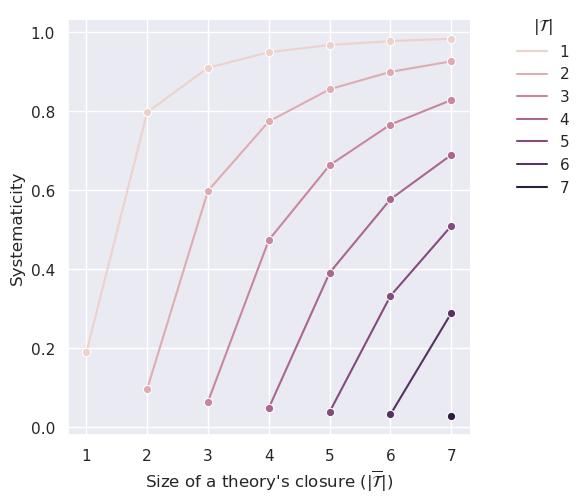

In [27]:
plot_sys_measure(sys_data, "sys_mm", param_name="gamma", param_value=0.9)
plt.show()

plot_sys_measure(sys_data, "sys_mm", param_name="gamma", param_value=0.5)
plt.show()

plot_sys_measure(sys_data, "sys_mm", param_name="gamma", param_value=0.7)
plt.show()

plot_sys_measure(sys_data, "sys_mm", param_name="gamma", param_value=0.1)
plt.show()

#### Effective Content Systematicity

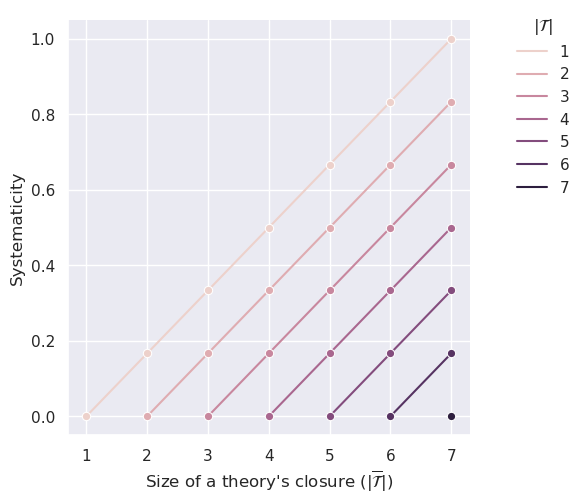

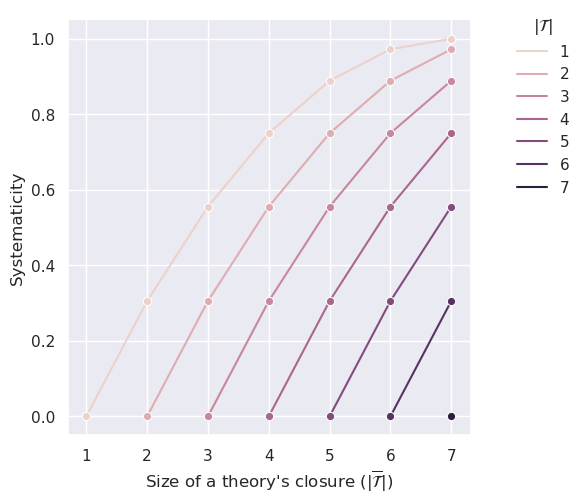

In [19]:
plot_sys_measure(sys_data, "sys_ec")
plt.show()

plot_sys_measure(sys_data, "sys_ec_2")
plt.show()

#### Content-Simplicity Weighted Systematicity

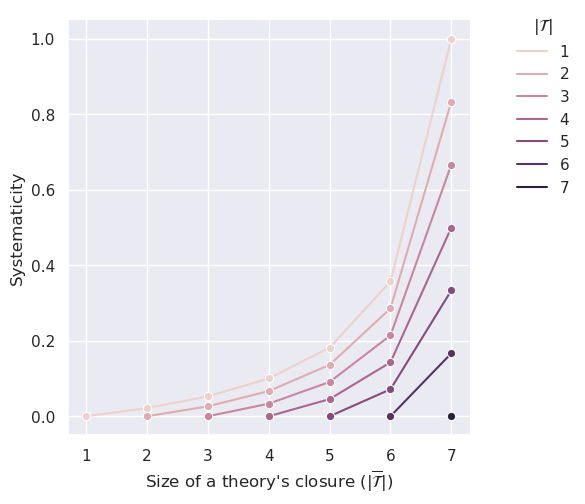

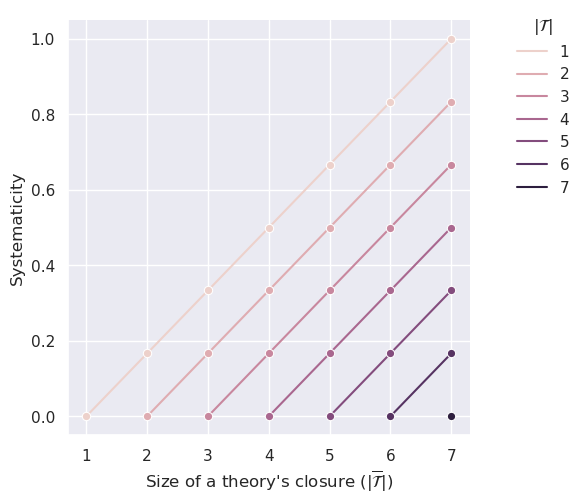

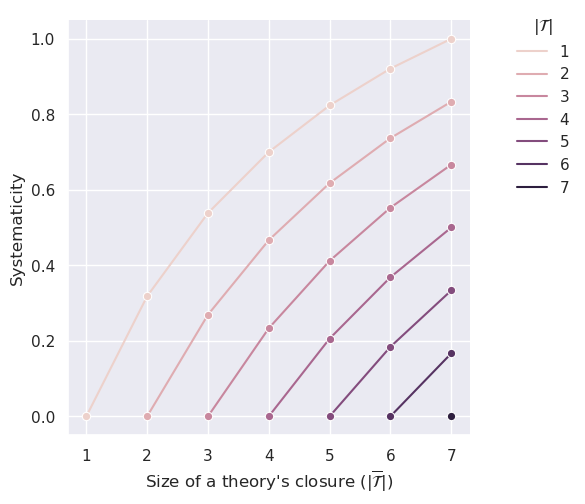

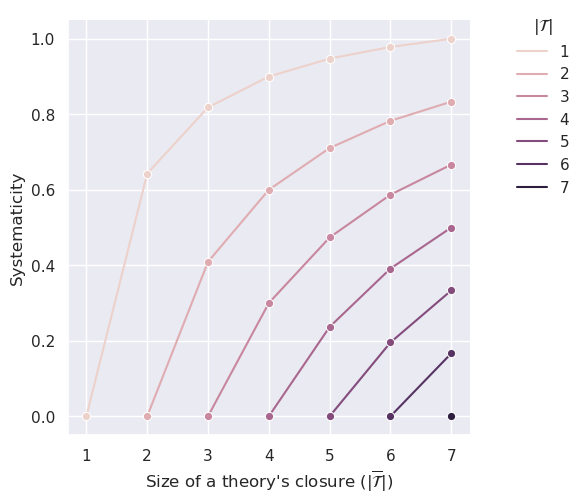

In [20]:
plot_sys_measure(sys_data, "sys_csw_alpha", param_name="alpha", param_value=0.1)
plt.show()

plot_sys_measure(sys_data, "sys_csw_alpha", param_name="alpha", param_value=0.5)
plt.show()

plot_sys_measure(sys_data, "sys_csw_alpha", param_name="alpha", param_value=0.7)
plt.show()

plot_sys_measure(sys_data, "sys_csw_alpha", param_name="alpha", param_value=0.9)
plt.show()

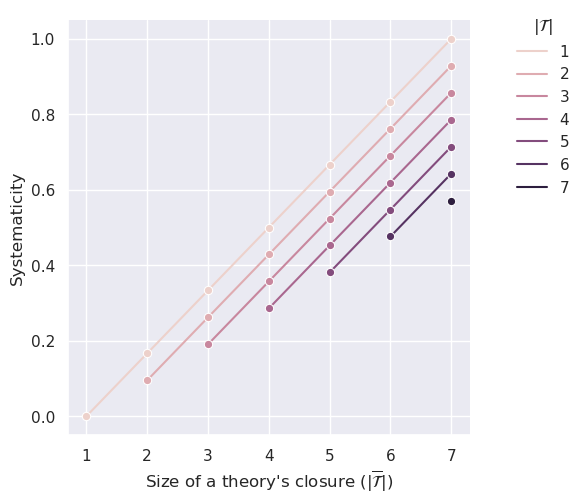

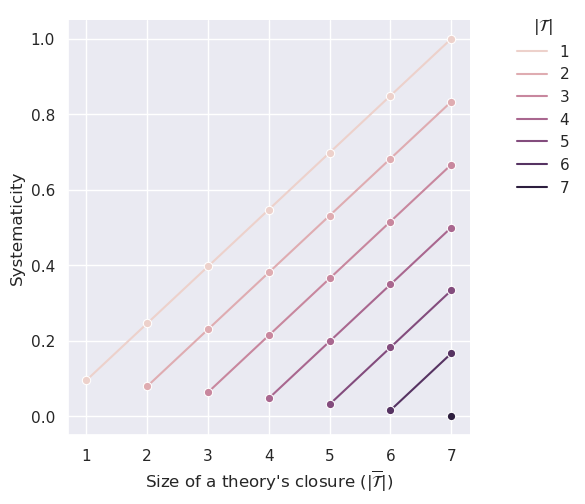

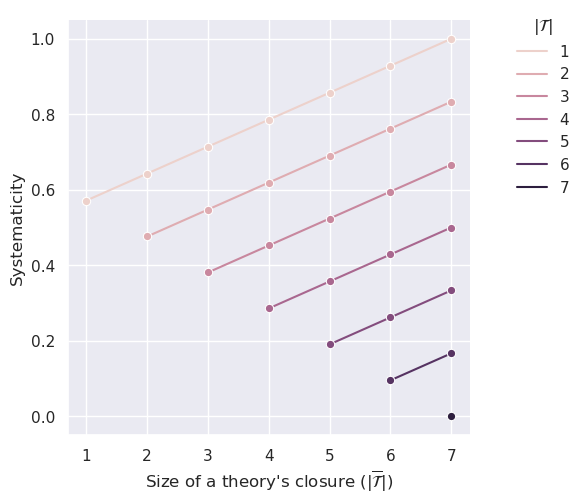

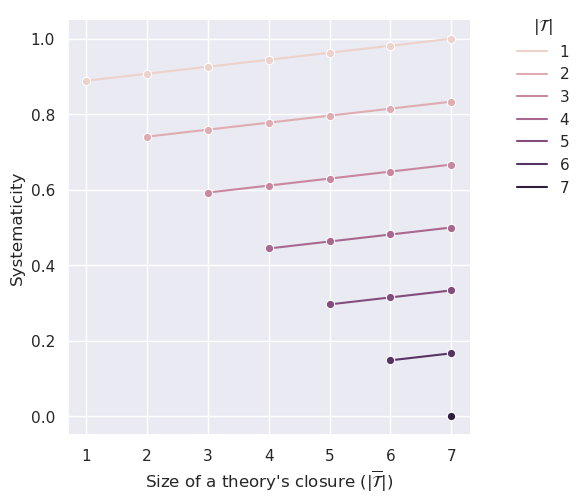

In [21]:
plot_sys_measure(sys_data, "sys_csw_beta", param_name="beta", param_value=0.3)
plt.show()

plot_sys_measure(sys_data, "sys_csw_beta", param_name="beta", param_value=0.525)
plt.show()

plot_sys_measure(sys_data, "sys_csw_beta", param_name="beta", param_value=0.7)
plt.show()

plot_sys_measure(sys_data, "sys_csw_beta", param_name="beta", param_value=0.9)
plt.show()

#### Relative Effective Content Systematicity

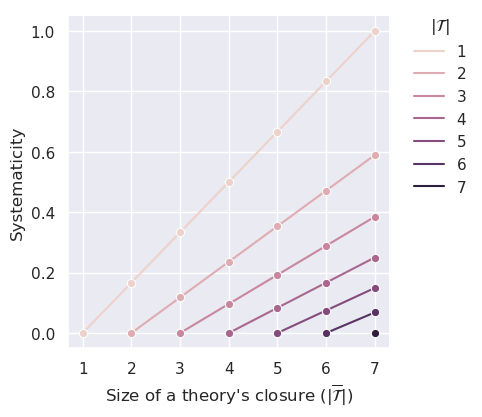

In [22]:
plot_sys_measure(sys_data, "sys_rec", scale=0.8)
plt.show()

### Sigma-Based Measures

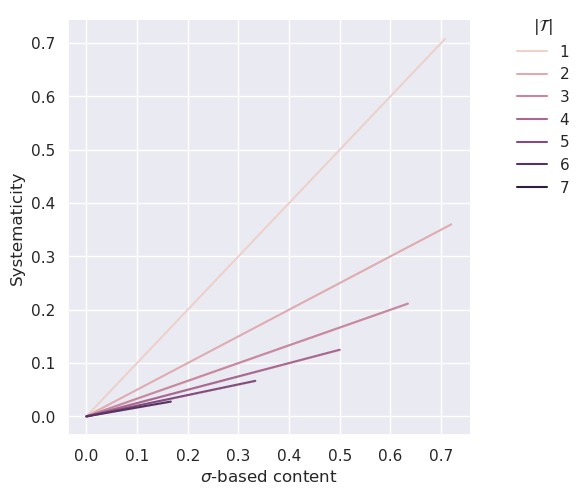

In [30]:
g = sns.relplot(data=data_grec,
                x="sigma_content", 
                y="sys_grec",
                hue="theory_size",
                kind="line", 
                #marker='o'
               )
plt.ylabel("Systematicity")
plt.xlabel(r"$\sigma$-based content")

sns.move_legend(
    g, "upper right",
    bbox_to_anchor=(1, 1), 
    title=r"$\vert \mathcal{T} \vert$",
)
plt.show()

### D5 - Internal Connectedeness

In [32]:
from re_technical_report import sys_grec, conditional_restricted_sigma
from theodias  import StandardPosition, DAGDialecticalStructure

def info_theory(theory, tau, n):
    print("------------------")
    print(f"Theory: {theory}")
    print(f"Sigma systematicity: {sys_grec(tau, theory)}")
    # restricted domain (S\T)
    domain = StandardPosition.from_set(tau.sentence_pool().domain().as_set() - theory.domain().as_set(), n)
    restr_gamma = [pos for pos in tau.consistent_positions() if pos.domain()==domain]
    #print(f"Restricted Gamma: {restr_gamma}")
    print(f"Restricted sigma: {len(restr_gamma)}")
    print(f"Restricted conditional sigma: {conditional_restricted_sigma(tau, domain, theory)}")
    

In [11]:

# SYS1
n = 8
arguments = [[1,2,3],[1,2,4],[1,2,5],[1,2,6],
             [7,3],[7,4],[8,5],[8,6]]
tau = DAGDialecticalStructure.from_arguments(arguments, n)
t1 = StandardPosition.from_set({1,2}, n)
t2 = StandardPosition.from_set({7,8}, n)

info_theory(t1, tau, n)
info_theory(t2, tau, n)


------------------
Theory: {1, 2}
Sigma systematicity: 0.31853082990266407
Restricted sigma: 25
Restricted conditional sigma: 4
------------------
Theory: {8, 7}
Sigma systematicity: 0.39454013971835805
Restricted sigma: 49
Restricted conditional sigma: 4


In [12]:
# SYS2
n = 7
arguments = [[1,2,3],[1,4,5],[6,3],[7,5]]
tau = DAGDialecticalStructure.from_arguments(arguments, n)
t1 = StandardPosition.from_set({1,2,4}, n)
t2 = StandardPosition.from_set({1,6,7}, n)

info_theory(t1, tau, n)
info_theory(t2, tau, n)


------------------
Theory: {1, 2, 4}
Sigma systematicity: 0.143609027817842
Restricted sigma: 9
Restricted conditional sigma: 4
------------------
Theory: {1, 6, 7}
Sigma systematicity: 0.20557998434117178
Restricted sigma: 16
Restricted conditional sigma: 4


### D6 - External Connectedeness

In [13]:
# SYS3
n = 6
arguments = [[1,2,4],[1,3,5]]
tau = DAGDialecticalStructure.from_arguments(arguments, n)
t1 = StandardPosition.from_set({1}, n)
t2 = StandardPosition.from_set({6}, n)

info_theory(t1, tau, n)
info_theory(t2, tau, n)


------------------
Theory: {1}
Sigma systematicity: 0.7813781191217037
Restricted sigma: 32
Restricted conditional sigma: 18
------------------
Theory: {6}
Sigma systematicity: 0.0
Restricted sigma: 25
Restricted conditional sigma: 25
